In [1]:
%pip install pandas
%pip install numpy
%pip install torch
%pip install scikit-learn
%pip install matplotlib
%pip install tqdm
%pip install google
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, matthews_corrcoef, accuracy_score
from sklearn.utils import resample
import matplotlib.pyplot as plt
from tqdm import tqdm

DEVICE = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

# Hyperparameters
NUM_CLASSES = 2  # Binary classification (0: no signal peptide, 1: signal peptide)
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.001
MAX_LENGTH = 100  # maybe adjust
WINDOW_SIZE = 35  # sliding window (odd because model predicts center residue)
STRIDE = 1  # Step size

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/PBLRost/"
FASTA_PATH = os.path.join(DRIVE_PATH, "data/complete_set_unpartitioned.fasta")
MODEL_PATH = os.path.join(DRIVE_PATH, "models/2state_ohe_lstm_cnn_lin.pt")

Mounted at /content/drive


In [3]:
aas = 'ARNDCEQGHILKMFPSTWYV'
aa2idx = {aa: i for i, aa in enumerate(aas)}
idx2aa = {i: aa for aa, i in aa2idx.items()}
num_aa = len(aas)

def one_hot_encode_window(seq_window):
    """One-hot encode a sequence window"""
    encoding = np.zeros((len(seq_window), num_aa))

    for i, aa in enumerate(seq_window):
        if aa in aa2idx:
            encoding[i, aa2idx[aa]] = 1
        # Unknown amino acids remain as zero vectors (as is the default)
    return encoding

In [4]:
def create_sliding_windows(sequence, labels, window_size, stride=1):
    """Create sliding windows from sequence and corresponding labels"""
    windows = []
    window_labels = []
    positions = []

    # Pad sequence for edge cases
    pad_size = window_size // 2 # so starts classification after padding, at first real encoding
    padded_seq = 'X' * pad_size + sequence + 'X' * pad_size
    padded_labels = [0] * pad_size + labels + [0] * pad_size

    # Create sliding windows
    for i in range(0, len(sequence), stride):
        start_idx = i
        end_idx = i + window_size

        if end_idx <= len(padded_seq):
            window_seq = padded_seq[start_idx:end_idx]
            # Label for the center position of the window
            center_idx = start_idx + pad_size # residue to predict
            if center_idx < len(padded_labels):
                center_label = padded_labels[center_idx]

                windows.append(window_seq)
                window_labels.append(center_label)
                positions.append(i)  # Original position in sequence

    return windows, window_labels, positions

In [5]:
def load_and_preprocess_data(fasta_path):
    """Load FASTA data and preprocess for sliding window approach"""
    records = []

    with open(fasta_path, "r") as f:
        current_record = None
        for line in f:
            if line.startswith(">"):
                if current_record is not None:
                    if current_record["sequence"] is not None and current_record["label"] is not None:
                        records.append(current_record)

                uniprot_ac, kingdom, type_ = line[1:].strip().split("|")
                current_record = {
                    "uniprot_ac": uniprot_ac,
                    "kingdom": kingdom,
                    "type": type_,
                    "sequence": None,
                    "label": None
                }
            else:
                if current_record["sequence"] is None:
                    current_record["sequence"] = line.strip()
                elif current_record["label"] is None:
                    current_record["label"] = line.strip()

        # Add last record
        if current_record is not None:
            if current_record["sequence"] is not None and current_record["label"] is not None:
                records.append(current_record)

    print(f"Total records loaded: {len(records)}")

    # Convert to DataFrame
    df_raw = pd.DataFrame(records)

    # Filter out sequences with 'P' in labels (if needed)
    df = df_raw[~df_raw["label"].str.contains("P")]

    # Map signal peptide types to binary classification
    df["has_signal_peptide"] = df["type"].map({
        "NO_SP": 0,
        "LIPO": 1,
        "SP": 1,
        "TAT": 1,
        "TATLIPO": 1
    })

    # Balance the dataset at sequence level first
    df_majority = df[df["has_signal_peptide"] == 0]
    df_minority = df[df["has_signal_peptide"] == 1]

    if not df_minority.empty and not df_majority.empty:

        n_samples = min(len(df_majority), 5000) # Limit samples to 5000 to prevent high ram usage
        df_majority_sampled = resample(
            df_majority,
            replace=False, # sample without replacement
            n_samples=n_samples,
            random_state=42
        )
        df_balanced = pd.concat([df_majority_sampled, df_minority]) # Include all minority samples
    else:
        df_balanced = df.copy()


    # Convert residue-level labels to binary
    label_map = {'S': 1, 'T': 1, 'L': 1, 'I': 0, 'M': 0, 'O': 0}

    # Create sliding windows for all sequences
    all_windows = []
    all_labels = []
    all_seq_ids = []

    for idx, row in df_balanced.iterrows():
        sequence = row["sequence"]
        label_string = row["label"]

        # Convert label string to binary array
        residue_labels = [label_map.get(c, 0) for c in label_string]

        # Skip sequences where label length doesn't match sequence length
        if len(residue_labels) != len(sequence):
            print("A sequence length is not equal to the label length")
            continue

        # Create sliding windows for this sequence
        windows, window_labels, positions = create_sliding_windows(
            sequence, residue_labels, WINDOW_SIZE, STRIDE
        )

        all_windows.extend(windows)
        all_labels.extend(window_labels) # labels for center residue
        all_seq_ids.extend([idx] * len(windows)) # links windows and sequences (later split by seq id)

    print(f"Total windows created: {len(all_windows)}")
    print(f"Signal peptide windows: {sum(all_labels)}")
    print(f"Non-signal peptide windows: {len(all_labels) - sum(all_labels)}")

    return all_windows, all_labels, all_seq_ids

In [6]:
class SlidingWindowDataset(Dataset):
    def __init__(self, windows, labels, window_size):
        self.windows = windows
        self.labels = labels
        self.window_size = window_size

        # Pre-encode all windows
        self.encoded_windows = []
        for window in windows:
            encoded = one_hot_encode_window(window)
            self.encoded_windows.append(encoded)

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        return {
            'window': torch.tensor(self.encoded_windows[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [7]:
class CNNLSTMSignalPeptideClassifier(nn.Module):
    def __init__(self, window_size, num_aa, hidden_dim=128, num_layers=2,
                 cnn_channels=[64, 32], lstm_hidden=64, lstm_layers=2,
                 use_bidirectional=True, dropout=0.3):
        super().__init__()
        self.window_size = window_size
        self.num_aa = num_aa
        self.use_bidirectional = use_bidirectional
        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers

        # CNN layers for local pattern detection
        self.conv_layers = nn.ModuleList()
        in_channels = num_aa

        for out_channels in cnn_channels:
            self.conv_layers.append(nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm1d(out_channels),
                nn.ReLU(),
                nn.Dropout(dropout)
            ))
            in_channels = out_channels

        # LSTM layers for sequential dependencies
        # Input to LSTM: [batch_size, seq_len, features]
        lstm_input_size = cnn_channels[-1]  # Last CNN output channels
        self.lstm = nn.LSTM(
            input_size=lstm_input_size,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0,
            bidirectional=use_bidirectional
        )

        # Calculate LSTM output size
        lstm_output_size = lstm_hidden * (2 if use_bidirectional else 1)

        # Attention mechanism to focus on important positions
        self.attention = nn.Sequential(
            nn.Linear(lstm_output_size, lstm_output_size // 2),
            nn.ReLU(),
            nn.Linear(lstm_output_size // 2, 1)
        )

        # Final classification layers
        classifier_layers = []
        in_dim = lstm_output_size

        for _ in range(num_layers):
            classifier_layers.extend([
                nn.Linear(in_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            in_dim = hidden_dim

        # Binary classification output
        classifier_layers.append(nn.Linear(hidden_dim, 1))
        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        # x: [batch_size, window_size, num_aa]
        batch_size, seq_len, num_features = x.size()

        # need [batch_size, num_aa, window_size] for Conv1d
        x = x.transpose(1, 2)  # [batch_size, num_aa, window_size]

        # Apply CNN layers
        for conv_layer in self.conv_layers:
            x = conv_layer(x)

        # need [batch_size, seq_len, features] for LSTM
        x = x.transpose(1, 2)  # [batch_size, window_size, cnn_channels[-1]]

        # LSTM processing
        lstm_out, (hidden, cell) = self.lstm(x)
        # lstm_out: [batch_size, seq_len, lstm_hidden * directions]

        # Apply attention mechanism
        attention_weights = self.attention(lstm_out)  # [batch_size, seq_len, 1]
        attention_weights = F.softmax(attention_weights, dim=1)

        # Weighted sum of LSTM outputs
        attended_output = torch.sum(lstm_out * attention_weights, dim=1)
        # attended_output: [batch_size, lstm_hidden * directions]

        # Final classification
        logits = self.classifier(attended_output)
        return logits.squeeze(-1)  # Remove last dimension


class CNNLSTMSignalPeptideClassifierV2(nn.Module):
    """Alternative version with different CNN-LSTM integration"""
    def __init__(self, window_size, num_aa, hidden_dim=128, num_layers=2,
                 cnn_channels=[64, 32], lstm_hidden=64, lstm_layers=1,
                 use_bidirectional=True, dropout=0.3):
        super().__init__()
        self.window_size = window_size
        self.num_aa = num_aa

        # CNN feature extractor
        self.cnn_backbone = nn.Sequential(
            # First conv block
            nn.Conv1d(num_aa, cnn_channels[0], kernel_size=5, padding=2),
            nn.BatchNorm1d(cnn_channels[0]),
            nn.ReLU(),
            nn.Dropout(dropout),

            # Second conv block
            nn.Conv1d(cnn_channels[0], cnn_channels[1], kernel_size=3, padding=1),
            nn.BatchNorm1d(cnn_channels[1]),
            nn.ReLU(),
            nn.Dropout(dropout),

            # Third conv block
            nn.Conv1d(cnn_channels[1], cnn_channels[1], kernel_size=3, padding=1),
            nn.BatchNorm1d(cnn_channels[1]),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # LSTM for sequential modeling
        self.lstm = nn.LSTM(
            input_size=cnn_channels[-1],
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0,
            bidirectional=use_bidirectional
        )

        # Calculate dimensions
        lstm_output_size = lstm_hidden * (2 if use_bidirectional else 1)

        # Global pooling options
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(lstm_output_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1)
        )

    def forward(self, x):
        # x: [batch_size, window_size, num_aa]
        batch_size = x.size(0)

        # CNN feature extraction
        x = x.transpose(1, 2)  # [batch_size, num_aa, window_size]
        cnn_features = self.cnn_backbone(x)

        # Prepare for LSTM
        x = cnn_features.transpose(1, 2)  # [batch_size, window_size, features]

        # LSTM processing
        lstm_out, _ = self.lstm(x)

        # Global pooling over sequence dimension
        lstm_out = lstm_out.transpose(1, 2)  # [batch_size, features, seq_len]
        pooled = self.global_pool(lstm_out).squeeze(-1)  # [batch_size, features]

        # Classification
        logits = self.classifier(pooled)
        return logits.squeeze(-1)

In [8]:
def train_model(model, train_loader, val_loader, num_epochs, device,
                        lr=0.001, weight_decay=1e-5, patience=5):
    """Enhanced training function with gradient clipping and better scheduling"""
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss()

    # More sophisticated learning rate scheduling
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', patience=patience, factor=0.5, verbose=True
    )

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_batches = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in progress_bar:
            windows = batch['window'].to(device)
            labels = batch['label'].to(device).float()

            optimizer.zero_grad()

            try:
                logits = model(windows)
                loss = criterion(logits, labels)

                loss.backward()

                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()

                train_loss += loss.item()
                train_batches += 1

                progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

            except RuntimeError as e:
                print(f"Error in training batch: {e}")
                continue

        if train_batches == 0:
            print("No successful training batches!")
            break

        avg_train_loss = train_loss / train_batches
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0
        val_batches = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch in val_loader:
                windows = batch['window'].to(device)
                labels = batch['label'].to(device).float()

                try:
                    logits = model(windows)
                    loss = criterion(logits, labels)

                    val_loss += loss.item()
                    val_batches += 1

                    # Calculate accuracy
                    predictions = (torch.sigmoid(logits) > 0.5).float()
                    val_correct += (predictions == labels).sum().item()
                    val_total += labels.size(0)

                except RuntimeError as e:
                    print(f"Error in validation batch: {e}")
                    continue

        if val_batches == 0:
            print("No successful validation batches!")
            break

        avg_val_loss = val_loss / val_batches
        val_accuracy = val_correct / val_total
        val_losses.append(avg_val_loss)

        # Learning rate scheduling
        scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # Early stopping and best model saving
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), MODEL_PATH)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience * 2:  # More patience for complex model
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, val_losses


In [12]:
# compute percentage of false predicted labels
def sequence_level_accuracy(labels, predictions):
    """Compute the accuracy of individual window predictions."""
    correct = 0
    total = len(labels) # Total number of windows

    # Ensure labels and predictions have the same length
    if len(labels) != len(predictions):
        print("Warning: Length of labels and predictions do not match.")
        # Adjust total to the minimum length if lengths differ
        total = min(len(labels), len(predictions))
        labels = labels[:total]
        predictions = predictions[:total]


    for pred, label in zip(predictions, labels):
        # Now comparing individual predictions and labels
        if pred == label:
            correct += 1
    return correct / total

In [10]:
def evaluate_model(model, test_loader, device):
    """Evaluate the sliding window model"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            windows = batch['window'].to(device)
            labels = batch['label'].to(device)

            logits = model(windows)
            probabilities = torch.sigmoid(logits)
            predictions = (probabilities > 0.5).long()

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())

    # Calculate metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=['No Signal', 'Signal']))

    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    mcc = matthews_corrcoef(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    seq_acc = sequence_level_accuracy(all_labels, all_preds)

    print(f"F1 Score (weighted): {f1_weighted:.4f}")
    print(f"F1 Score (macro): {f1_macro:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Sequence-level Accuracy: {seq_acc:.4f}")

    return all_preds, all_labels, all_probs

def predict_sequence(model, sequence, window_size, device, threshold=0.5):
    """Predict signal peptide positions for a full sequence"""
    model.eval()

    # Create dummy labels (we don't need them for prediction)
    dummy_labels = [0] * len(sequence)

    # Create sliding windows
    windows, _, positions = create_sliding_windows(sequence, dummy_labels, window_size, stride=1)

    # Encode windows
    encoded_windows = [one_hot_encode_window(window) for window in windows]

    predictions = []
    probabilities = []

    with torch.no_grad():
        for encoded_window in encoded_windows:
            window_tensor = torch.tensor(encoded_window, dtype=torch.float32).unsqueeze(0).to(device)
            logit = model(window_tensor)
            prob = torch.sigmoid(logit).item()
            pred = int(prob > threshold)

            predictions.append(pred)
            probabilities.append(prob)

    return predictions, probabilities, positions

In [11]:
# Load and preprocess data with sliding windows
windows, labels, seq_ids = load_and_preprocess_data(FASTA_PATH)

# Split data (keeping track of sequence IDs to avoid data leakage)
unique_seq_ids = list(set(seq_ids))
train_seq_ids, test_seq_ids = train_test_split(unique_seq_ids, test_size=0.2, random_state=42)
train_seq_ids, val_seq_ids = train_test_split(train_seq_ids, test_size=0.2, random_state=42)

# Create splits based on sequence IDs (no mix/data leakage between sequences)
train_indices = [i for i, seq_id in enumerate(seq_ids) if seq_id in train_seq_ids]
val_indices = [i for i, seq_id in enumerate(seq_ids) if seq_id in val_seq_ids]
test_indices = [i for i, seq_id in enumerate(seq_ids) if seq_id in test_seq_ids]

# Setup of split of windows and labels
train_windows = [windows[i] for i in train_indices]
train_labels = [labels[i] for i in train_indices]

val_windows = [windows[i] for i in val_indices]
val_labels = [labels[i] for i in val_indices]

test_windows = [windows[i] for i in test_indices]
test_labels = [labels[i] for i in test_indices]

print(f"Train windows: {len(train_windows)}")
print(f"Validation windows: {len(val_windows)}")
print(f"Test windows: {len(test_windows)}")

# Create datasets and loaders
train_dataset = SlidingWindowDataset(train_windows, train_labels, WINDOW_SIZE)
val_dataset = SlidingWindowDataset(val_windows, val_labels, WINDOW_SIZE)
test_dataset = SlidingWindowDataset(test_windows, test_labels, WINDOW_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model (version 1, prob better performance)
model = CNNLSTMSignalPeptideClassifier(
    window_size=WINDOW_SIZE,
    num_aa=num_aa,
    hidden_dim=128,
    num_layers=2,
    cnn_channels=[64, 32],
    lstm_hidden=64,
    lstm_layers=2,
    use_bidirectional=True,
    dropout=0.3
).to(DEVICE)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Train model
train_losses, val_losses = train_model(model, train_loader, val_loader, EPOCHS, DEVICE)


Total records loaded: 25693


/tmp/ipython-input-5-2876765950.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["has_signal_peptide"] = df["type"].map({


Total windows created: 806011
Signal peptide windows: 153863
Non-signal peptide windows: 652148
Train windows: 515774
Validation windows: 129009
Test windows: 161228
Model parameters: 201,762


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/10: 100%|██████████| 16118/16118 [17:26<00:00, 15.40it/s, loss=0.0547]


Epoch 1/10 - Train Loss: 0.0999, Val Loss: 0.0831, Val Acc: 0.9711


Epoch 2/10: 100%|██████████| 16118/16118 [17:29<00:00, 15.36it/s, loss=0.0137]


Epoch 2/10 - Train Loss: 0.0671, Val Loss: 0.0852, Val Acc: 0.9725


Epoch 3/10: 100%|██████████| 16118/16118 [17:21<00:00, 15.47it/s, loss=0.0130]


Epoch 3/10 - Train Loss: 0.0563, Val Loss: 0.0909, Val Acc: 0.9729


Epoch 4/10: 100%|██████████| 16118/16118 [17:20<00:00, 15.49it/s, loss=0.1402]


Epoch 4/10 - Train Loss: 0.0482, Val Loss: 0.0959, Val Acc: 0.9729


Epoch 5/10: 100%|██████████| 16118/16118 [17:18<00:00, 15.53it/s, loss=0.0041]


Epoch 5/10 - Train Loss: 0.0428, Val Loss: 0.0911, Val Acc: 0.9742


Epoch 6/10: 100%|██████████| 16118/16118 [17:15<00:00, 15.57it/s, loss=0.0031]


Epoch 6/10 - Train Loss: 0.0387, Val Loss: 0.0888, Val Acc: 0.9742


Epoch 7/10: 100%|██████████| 16118/16118 [17:12<00:00, 15.62it/s, loss=0.0033]


Epoch 7/10 - Train Loss: 0.0350, Val Loss: 0.1028, Val Acc: 0.9747


Epoch 8/10: 100%|██████████| 16118/16118 [17:10<00:00, 15.64it/s, loss=0.0020]


Epoch 8/10 - Train Loss: 0.0282, Val Loss: 0.1007, Val Acc: 0.9766


Epoch 9/10: 100%|██████████| 16118/16118 [17:15<00:00, 15.56it/s, loss=0.0522]


Epoch 9/10 - Train Loss: 0.0253, Val Loss: 0.1073, Val Acc: 0.9751


Epoch 10/10: 100%|██████████| 16118/16118 [17:13<00:00, 15.60it/s, loss=0.0602]


Epoch 10/10 - Train Loss: 0.0242, Val Loss: 0.1152, Val Acc: 0.9752

Final Evaluation:


Evaluating: 100%|██████████| 5039/5039 [01:39<00:00, 50.70it/s]


Classification Report:
              precision    recall  f1-score   support

   No Signal       0.98      0.99      0.98    130433
      Signal       0.94      0.92      0.93     30795

    accuracy                           0.97    161228
   macro avg       0.96      0.95      0.96    161228
weighted avg       0.97      0.97      0.97    161228



TypeError: object of type 'numpy.int64' has no len()


Final Evaluation:


Evaluating: 100%|██████████| 5039/5039 [01:34<00:00, 53.06it/s]


Classification Report:
              precision    recall  f1-score   support

   No Signal       0.98      0.99      0.98    130433
      Signal       0.94      0.92      0.93     30795

    accuracy                           0.97    161228
   macro avg       0.96      0.95      0.96    161228
weighted avg       0.97      0.97      0.97    161228

F1 Score (weighted): 0.9737
F1 Score (macro): 0.9573
Matthews Correlation Coefficient: 0.9147
Accuracy: 0.9739
Sequence-level Accuracy: 0.9739


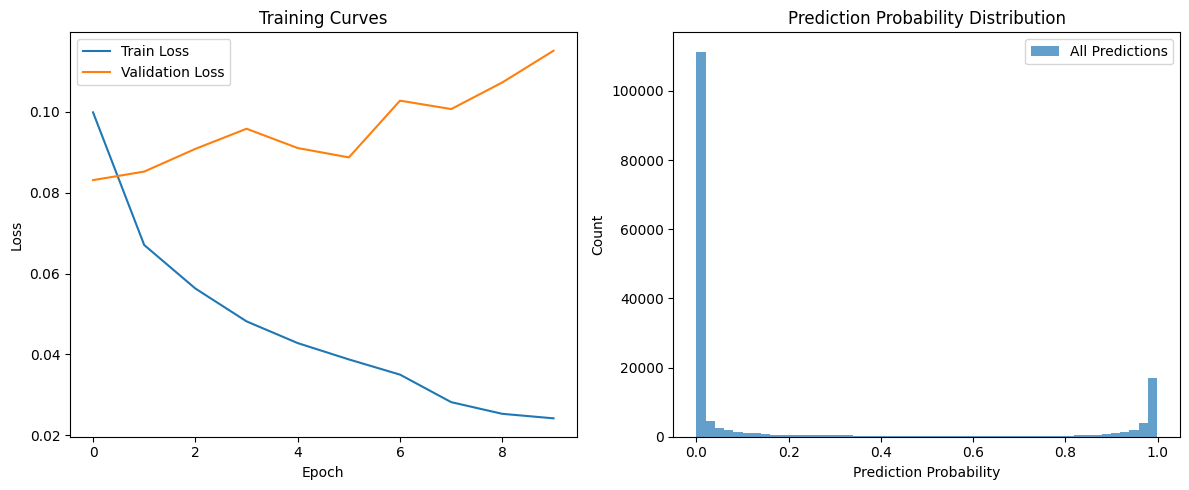

In [13]:
# Load best model for evaluation
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))

# Evaluate model
print("\nFinal Evaluation:")
predictions, labels_true, probabilities = evaluate_model(model, test_loader, DEVICE)

# Plot training curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curves')

plt.subplot(1, 2, 2)
plt.hist(probabilities, bins=50, alpha=0.7, label='All Predictions')
plt.xlabel('Prediction Probability')
plt.ylabel('Count')
plt.title('Prediction Probability Distribution')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
# Example: Predict on a sample sequence
sample_sequence = "MKRREFLRTAGGATAAATAAAGTAAAQEGGGGAQVQPDFGGYLDGVDGGYEDLRGQSEVTIEVGASGNGG"
# correct labels : 11111111111111111111111111000000000000000000000000000000000000000000000
print(f"\nExample prediction for sequence: {sample_sequence}")
preds, probs, pos = predict_sequence(model, sample_sequence, WINDOW_SIZE, DEVICE)

print("Position\tAA\tProbability\tPrediction")
for i, (pred, prob, position) in enumerate(zip(preds, probs, pos)):
    aa = sample_sequence[position] if position < len(sample_sequence) else 'X'
    print(f"{position:3d}\t{aa}\t{prob:.3f}\t\t{'Signal' if pred else 'No Signal'}")

# Save final model
torch.save(model.state_dict(), MODEL_PATH)
print(f"\nFinal model saved to {MODEL_PATH}")



Example prediction for sequence: MKRREFLRTAGGATAAATAAAGTAAAQEGGGGAQVQPDFGGYLDGVDGGYEDLRGQSEVTIEVGASGNGG
Position	AA	Probability	Prediction
  0	M	0.981		Signal
  1	K	0.984		Signal
  2	R	0.985		Signal
  3	R	0.987		Signal
  4	E	0.987		Signal
  5	F	0.986		Signal
  6	L	0.989		Signal
  7	R	0.989		Signal
  8	T	0.990		Signal
  9	A	0.991		Signal
 10	G	0.992		Signal
 11	G	0.992		Signal
 12	A	0.991		Signal
 13	T	0.991		Signal
 14	A	0.990		Signal
 15	A	0.988		Signal
 16	A	0.987		Signal
 17	T	0.980		Signal
 18	A	0.973		Signal
 19	A	0.983		Signal
 20	A	0.963		Signal
 21	G	0.868		Signal
 22	T	0.929		Signal
 23	A	0.889		Signal
 24	A	0.810		Signal
 25	A	0.325		No Signal
 26	Q	0.304		No Signal
 27	E	0.258		No Signal
 28	G	0.206		No Signal
 29	G	0.189		No Signal
 30	G	0.144		No Signal
 31	G	0.112		No Signal
 32	A	0.080		No Signal
 33	Q	0.051		No Signal
 34	V	0.028		No Signal
 35	Q	0.012		No Signal
 36	P	0.003		No Signal
 37	D	0.000		No Signal
 38	F	0.000		No Signal
 39	G	0.000		No Signal
 40	G	0.000		No